In [817]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
%matplotlib inline
np.random.seed(46)

In [818]:
#Paramétre de la simulation
TYPE_TIRAGE = "loto" # ou "euromillion"
NB_ANNEES = 10
NB_TIRAGE_PAR_SEMAINE  = 3
PRIX_LOTO = 2.20
NB_TIRAGE_LOTO_SEMAINE = 3
BASSE_FREQUENCE = False


#euromillion 
NB_TIRAGE_EUROMILLION_SEMAINE = 3
PRIX_EUROMILLION = 2.30



 
#Grille du joueur
GRILLE_NUMERO = [2,9,24,33,43]
GRILLE_ETOILE = [5]


#set joueur : 
grille_joueur = {"numero" :set(GRILLE_NUMERO) ,
          "etoile" : set(GRILLE_ETOILE)}


In [819]:
#calcule des gain  et des cout 

if_gain_loto = {
    "0,0":0,
    "1,0":0,
    "1,1": 2.20,
    "0,1": 2.20,
    "2,0": 4.50,
    "2,1": 11.10,
    "3,0": 18.60,
    "3,1": 50,
    "4,0": 335,
    "4,1": 817,
    "5,0": 68000,
    "5,1": 1000000
}
if_gain_euro_million = {
    "0,0":0,
    "1,0":0,
    "1,1":2.30,
    "0,1": 2.30,
    "2,0": 4.50,
    "2,1": 6.20,
    "3,0": 11.20,
    "3,1": 13.40,
    "2,2": 14.10,
    "4,0": 49.80,
    "3,2": 65.60,
    "4,1": 152.2,
    "4,2": 1773.40,
    "5,0": 23809,
    "5,1": 560301,
    "5,2": 10000000
}

def tirage_loto(numero_tirer=5,etoile_tirer=1) ->dict[str : tuple]:
    numero = np.arange(1,50)
    etoile = np.arange(1,10)
    numero = np.random.choice(numero,5,False)
    etoile = np.random.choice(etoile,1,False)    
    tirage = {"numero" : set(numero),
              "etoile" : set(etoile)}
    return tirage

def get_lower_frequence_number(data_frequence_sortie_numero:pd.DataFrame, data_frequence_sortie_etoile):
    # recupere les 5 numero et 1 etoile les moins sorties
    numero_sortie_moin_souvent = list(data_frequence_sortie_numero.nsmallest(5,"frequence")["frequence"].index)
    etoile_sortie_moin_souvent = list(data_frequence_sortie_etoile.nsmallest(1,"frequence")["frequence"].index)
    grille_a_joueur = {"numero" : set(numero_sortie_moin_souvent),
                       "etoile" : set(etoile_sortie_moin_souvent)}
    return grille_a_joueur


def Calcule_gain_loto(numero_joueur,tirage) -> float:
    nb_numero_gagniant = len(numero_joueur["numero"].intersection((tirage["numero"])))
    nb_etoile_gagniant = len(numero_joueur["etoile"].intersection((tirage["etoile"])))
    select_gain = str(f"{nb_numero_gagniant},{nb_etoile_gagniant}")
    return if_gain_loto[select_gain] - PRIX_LOTO

def Calcule_gain_euromillion(numero_joueur,tirage) -> float:
    nb_numero_gagniant = len(numero_joueur["numero"].intersection((tirage["numero"])))  
    nb_etoile_gagniant = len(numero_joueur["etoile"].intersection((tirage["etoile"])))
    select_gain = str(f"{nb_numero_gagniant},{nb_etoile_gagniant}")
    return if_gain_euro_million[select_gain]


def counter_to_pandas(dict_counter : Counter) -> pd.DataFrame:
    return pd.DataFrame.from_dict(dict_counter,"index",columns=["frequence"])

def tirages_loto(numero_joueur,limit_annee = 30,nombre_tirage_semaine=3,n_joueur_basse_frequence=False)-> tuple[pd.DataFrame,pd.DataFrame,pd.DataFrame]:
    data = []
    gain_cumuler = 0
    depense_cumuler = 0
    partie_jouer = 0
    annee = 0
    gain_semaine = 0
    jackpot = 0
    dict_frequence_etoile = Counter(np.arange(1,50))
    dict_frequence_numero = Counter(np.arange(1,50))
    win = True
    while win and annee < limit_annee:
        # print(gain_ans)
        annee += 1
        for semaine in range(0,52):
            gain_semaine +=1
            for jour in range(0,3):
                depense_cumuler += PRIX_LOTO
                partie_jouer +=1
                tirage_n_gagniant = tirage_loto()
                dict_frequence_numero.update(Counter(tirage_n_gagniant["numero"]))
                dict_frequence_etoile.update(Counter(tirage_n_gagniant["etoile"]))
                if n_joueur_basse_frequence:
                    numero_joueur = get_lower_frequence_number(counter_to_pandas(dict_frequence_numero),counter_to_pandas(dict_frequence_etoile))
                    jackpot =  Calcule_gain_loto(numero_joueur,tirage_n_gagniant)
                else:
                    jackpot =  Calcule_gain_loto(numero_joueur,tirage_n_gagniant)
                gain_cumuler += jackpot
                data.append({
                    "Gain": jackpot,
                    "Gain_cumuler" : round(gain_cumuler,2),
                    "Depense_cumuler": round(depense_cumuler,2),
                    "Annee": annee,
                    "Semaine": gain_semaine,
                    "Numeros_joueur" : numero_joueur["numero"],
                    "Etoile_joueur" : numero_joueur["etoile"],
                    "Numero_gagnant": tirage_n_gagniant["numero"],
                    "Etoile_gagnante": tirage_n_gagniant["etoile"],
                    "Win" : jackpot>=0
                })
                
                if jackpot >= 100000:
                    print(jackpot)
                    win = False
    print("gain : ",gain_cumuler)
    print("depense : ",depense_cumuler)
    print("annee : ",annee)
    print("semaine : ",gain_semaine)
    print("partie jouer : ",partie_jouer)
    historique_tirage = pd.DataFrame(data).set_index("Annee")
    count_numero_sortie = Counter(chain.from_iterable(historique_tirage.reset_index()["Numero_gagnant"].values))
    count_etoile_sortie = Counter(chain.from_iterable(historique_tirage.reset_index()["Etoile_gagnante"].values))
    numero_gagniant_repartition = pd.DataFrame.from_dict(count_numero_sortie,"index",columns=["frequence"])
    etoile_gagniant_repartition = pd.DataFrame.from_dict(count_etoile_sortie,"index",columns=["frequence"])




    return  historique_tirage,numero_gagniant_repartition, etoile_gagniant_repartition

In [820]:
# Simulation
data_loto,repartition_numero, repartition_etoile =  tirages_loto(grille_joueur,NB_ANNEES,NB_TIRAGE_PAR_SEMAINE,BASSE_FREQUENCE)

gain :  -2467.8999999999983
depense :  3431.9999999999154
annee :  10
semaine :  520
partie jouer :  1560


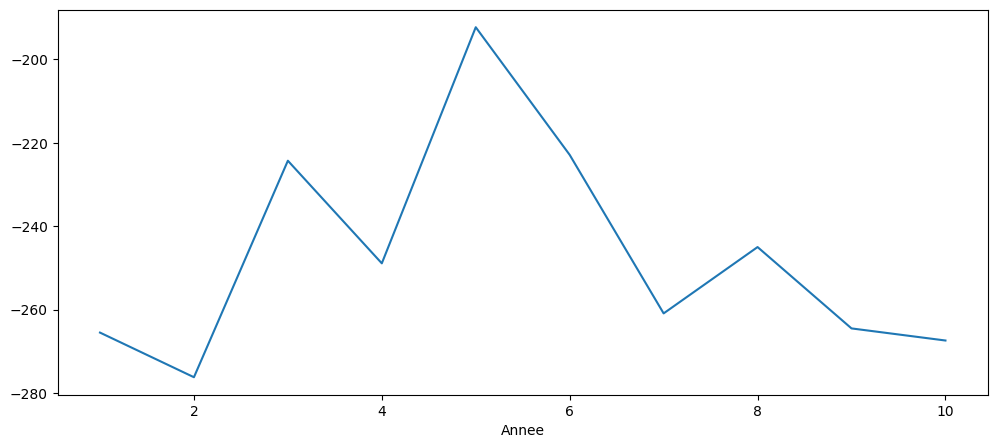

In [821]:
#Repartition des gain sur 1 ans
data_loto.groupby("Annee")["Gain"].sum().plot(figsize=[12,5]);

In [822]:
#top 10 des plus gros gros gains
data_loto.nlargest(20,"Gain").nlargest(50,"Gain")

,Gain,Gain_cumuler,Depense_cumuler,Semaine,Numeros_joueur,Etoile_joueur,Numero_gagnant,Etoile_gagnante,Win
Annee,,,,,,,,,
5,47.8,-1183.1,1685.2,256,"{33, 2, 9, 43, 24}",{5},"{2, 8, 43, 12, 24}",{5},True
4,16.4,-905.2,1236.4,188,"{33, 2, 9, 43, 24}",{5},"{33, 9, 17, 24, 26}",{6},True
5,16.4,-1119.1,1537.8,233,"{33, 2, 9, 43, 24}",{5},"{33, 2, 9, 41, 45}",{8},True
9,16.4,-2121.3,3005.2,456,"{33, 2, 9, 43, 24}",{5},"{33, 2, 38, 9, 25}",{1},True
3,16.4,-726.7,968.0,147,"{33, 2, 9, 43, 24}",{5},"{9, 43, 24, 26, 31}",{9},True
6,8.9,-1200.5,1720.4,261,"{33, 2, 9, 43, 24}",{5},"{33, 10, 46, 24, 29}",{5},True
7,8.9,-1482.6,2140.6,325,"{33, 2, 9, 43, 24}",{5},"{7, 9, 16, 48, 24}",{5},True
7,8.9,-1445.4,2085.6,316,"{33, 2, 9, 43, 24}",{5},"{9, 10, 48, 18, 24}",{5},True
6,8.9,-1355.9,1955.8,297,"{33, 2, 9, 43, 24}",{5},"{33, 2, 10, 20, 21}",{5},True


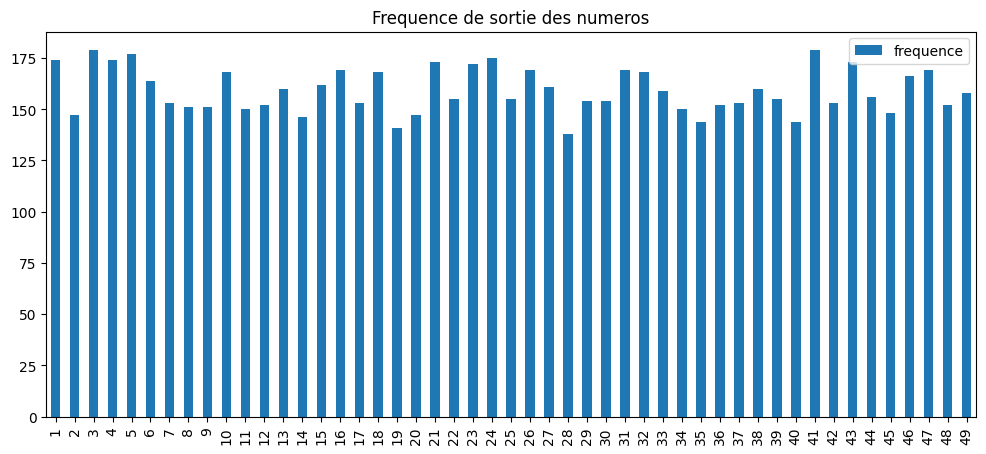

In [823]:
#frequence de sortie des numeros
repartition_numero.sort_index().plot(kind="bar",figsize=[12,5])
plt.title("Frequence de sortie des numeros");


In [824]:
# EXEMPLE recupere les nombres les moins souvent sortie
numero_sortie_moin_souvent = list(repartition_numero.nsmallest(5,"frequence")["frequence"].index)
etoile_sortie_moin_souvent = list(repartition_etoile.nsmallest(1,"frequence")["frequence"].index)
display(numero_sortie_moin_souvent,etoile_sortie_moin_souvent)




[28, 19, 40, 35, 14]

[3]

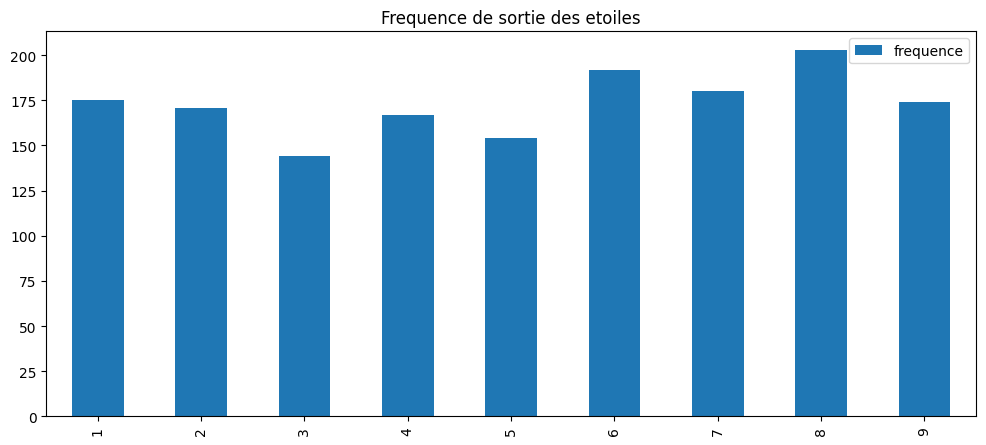

In [825]:
#frequence de sortie des etoiles
repartition_etoile.sort_index().plot(kind="bar",figsize=[12,5])
plt.title("Frequence de sortie des etoiles");

In [826]:
data_loto["Numero_gagnant"].apply(Counter)

Annee
1       {36: 1, 5: 1, 4: 1, 43: 1, 14: 1}
1      {2: 1, 39: 1, 11: 1, 23: 1, 30: 1}
1      {40: 1, 9: 1, 49: 1, 22: 1, 23: 1}
1      {33: 1, 5: 1, 11: 1, 20: 1, 24: 1}
1     {37: 1, 13: 1, 46: 1, 18: 1, 20: 1}
                     ...                 
10       {1: 1, 2: 1, 35: 1, 5: 1, 49: 1}
10      {3: 1, 4: 1, 43: 1, 23: 1, 26: 1}
10     {32: 1, 4: 1, 44: 1, 13: 1, 23: 1}
10     {3: 1, 13: 1, 14: 1, 48: 1, 20: 1}
10     {4: 1, 38: 1, 10: 1, 26: 1, 30: 1}
Name: Numero_gagnant, Length: 1560, dtype: object

In [827]:
dict_frequence = Counter(np.arange(1,50))

dict_frequence.update(Counter(tirage_loto()["numero"]))
dict_frequence

pandas_frequence = pd.DataFrame.from_dict(dict_frequence,"index",columns=["frequence"])
pandas_frequence
# numero_sortie_frequence = pd.DataFrame.from_dict(Counter(np.arange(1,50)),"index",columns=["frequence"])
# etoile_sortie_frequence = pd.DataFrame.from_dict(Counter(np.arange(1,10)),"index",columns=["frequence"])
# etoile_sortie_frequence



,frequence
1,1
2,1
3,1
4,1
5,1
6,1
7,1
8,1
9,1
10,2


In [828]:
numero_count_sortie =  pd.DataFrame.from_dict(Counter(tirage_loto()["numero"]) ,"index",columns=["frequence"])
